# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [45]:
# !pip install modin[dask]

In [46]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, MeanShift

from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor # Adaptive Boosting

from sklearn.metrics import roc_auc_score, fbeta_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix

from scipy import stats
from time import time

sns.set(style="ticks", color_codes=True)

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [47]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

/Users/nareshsharma/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [49]:
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [50]:
# look at the null distribution per column
null_data = azdias.isnull().sum()[azdias.isnull().sum() > 0]
dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/azdias.shape[0], 2)}
df_nulls = pd.DataFrame(data=dict, index=null_data.index)
df_nulls.sort_values(by='pct', ascending=False, inplace=True)

In [51]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

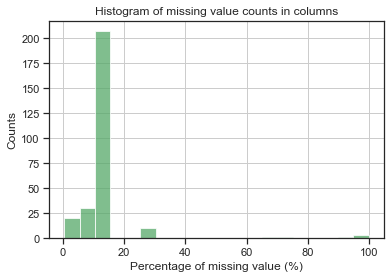

                              nulls    pct
ALTER_KIND4                  890016  99.86
ALTER_KIND3                  885051  99.31
ALTER_KIND2                  861722  96.69
ALTER_KIND1                  810163  90.90
EXTSEL992                    654153  73.40
KK_KUNDENTYP                 584612  65.60
ALTERSKATEGORIE_FEIN         262947  29.50
D19_SOZIALES                 257113  28.85
D19_LOTTO                    257113  28.85
D19_BANKEN_ONLINE_QUOTE_12   257113  28.85
D19_GESAMT_ONLINE_QUOTE_12   257113  28.85
D19_KONSUMTYP                257113  28.85
D19_LETZTER_KAUF_BRANCHE     257113  28.85
D19_TELKO_ONLINE_QUOTE_12    257113  28.85
D19_VERSAND_ONLINE_QUOTE_12  257113  28.85
D19_VERSI_ONLINE_QUOTE_12    257113  28.85


nulls    16
pct      16
dtype: int64

In [52]:
plot_hist_missing_col(df_nulls)
print(df_nulls[df_nulls.pct > 20])
df_nulls[df_nulls.pct > 20].count()

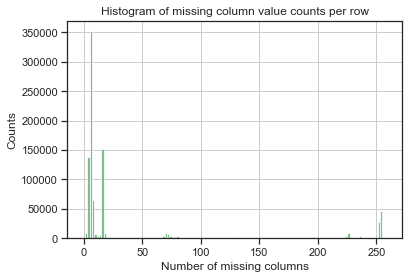

In [53]:
# Now let's also look at the pct of missing values per row, across columns
null_row_counts = azdias.isnull().sum(axis=1)
null_row_counts.values

plt.hist(null_row_counts.values, bins=np.arange(-1,null_row_counts.max()+1,2), facecolor='g', alpha=0.75)

plt.xlabel('Number of missing columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of missing column value counts per row', fontsize=12)
plt.grid(True)
plt.show()

In [54]:
# from the above we can see that most of the rows contain less than 20 columns having null values.
# Let's drop these rows, as otherwise imputing values for all of them might create a wrong bias
print(azdias.shape)
azdias = azdias.dropna(thresh=len(azdias.columns)-20)
azdias = azdias.reset_index(drop=True)
azdias.shape

(891221, 366)


(744305, 366)

In [55]:
# now let's once again see the missing data distribution per column
null_data = azdias.isnull().sum()[azdias.isnull().sum() > 0]
dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/azdias.shape[0], 2)}
df_nulls = pd.DataFrame(data=dict, index=null_data.index)
df_nulls.sort_values(by='pct', ascending=False, inplace=True)

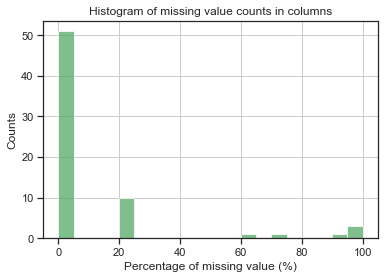

                              nulls    pct
ALTER_KIND4                  743272  99.86
ALTER_KIND3                  739080  99.30
ALTER_KIND2                  719685  96.69
ALTER_KIND1                  674832  90.67
EXTSEL992                    525002  70.54
KK_KUNDENTYP                 470487  63.21
ALTERSKATEGORIE_FEIN         171813  23.08
D19_BANKEN_ONLINE_QUOTE_12   167810  22.55
D19_VERSI_ONLINE_QUOTE_12    167810  22.55
D19_VERSAND_ONLINE_QUOTE_12  167810  22.55
D19_TELKO_ONLINE_QUOTE_12    167810  22.55
D19_SOZIALES                 167810  22.55
D19_LOTTO                    167810  22.55
D19_LETZTER_KAUF_BRANCHE     167810  22.55
D19_KONSUMTYP                167810  22.55
D19_GESAMT_ONLINE_QUOTE_12   167810  22.55


nulls    16
pct      16
dtype: int64

In [56]:
plot_hist_missing_col(df_nulls)
print(df_nulls[df_nulls.pct > 20])
df_nulls[df_nulls.pct > 20].count()

In [57]:
df_nulls.head(10)

,nulls,pct
ALTER_KIND4,743272,99.86
ALTER_KIND3,739080,99.30
ALTER_KIND2,719685,96.69
ALTER_KIND1,674832,90.67
EXTSEL992,525002,70.54
KK_KUNDENTYP,470487,63.21
ALTERSKATEGORIE_FEIN,171813,23.08
D19_BANKEN_ONLINE_QUOTE_12,167810,22.55
D19_VERSI_ONLINE_QUOTE_12,167810,22.55
D19_VERSAND_ONLINE_QUOTE_12,167810,22.55


In [59]:
# let's drop all the columns that have more than 24% of their values missing
print(azdias.shape)
azdias = azdias.drop(columns=df_nulls[df_nulls.pct > 24].index)
azdias.shape

(744305, 366)


(744305, 360)

In [18]:
# we can see that most of the columns contain less than 20% missing values.
# Let's drop the outlier columns
azdias = azdias.drop(columns=df_nulls[df_nulls.pct>20].index).reset_index(drop=True)
azdias.shape

(891221, 350)

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

In [ ]:
print(mailout_train.shape)
print((mailout_train.RESPONSE.sum())*100/len(mailout_train))

# Observations on data

1. The percentage of folks who actually become a customer is very less... hence we need a way to score with a higher recall

In [ ]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

In [ ]:
print(mailout_train.RESPONSE.isnull().sum())
mailout_nulls = get_null_counts(mailout_train)
plot_hist_missing_col(mailout_nulls)
mailout_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False)
# mailout_nulls

In [ ]:
print(len(set(azdias_sel_cols.columns).intersection(set(mailout_train.columns))))
print(set(azdias_sel_cols.columns) - set(mailout_train.columns))

In [ ]:
# Observations
# The columns that have a large number of nulls pretty much match the columns of general population, having large number of nulls
# Also all the columns that were used for clustering are available in the mailout dataset... so we should be able to apply the same cleanup process to this dataset
mailout_train.head()


In [ ]:
# First separate the datset into responses and their equivalent features
df_responses = mailout_train.RESPONSE
# df_features = mailout_train.drop(columns=['RESPONSE'])

In [ ]:
final_column_list

In [ ]:
print(mailout_train_cleaned.shape)
print(mailout_train.shape)
print(mailout_train[object_type_columns].isnull().sum())

In [ ]:
mailout_train_cleaned.isnull().sum()

In [ ]:
# Let's split the data into train and test data for our model buidling purposes
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_features_cleaned, df_responses, test_size=0.33, random_state=40)

In [ ]:
df_features = mailout_train_cleaned.drop(columns=['RESPONSE'])
df_responses = mailout_train_cleaned.RESPONSE
# df_responses.astype('int').head()
df_responses.isnull().sum()

In [ ]:
print(object_type_columns)
print(categorical_dict['CAMEO_DEU_2015'])
mailout_train[object_type_columns[0]].append(mailout_train[object_type_columns[1]]).unique()

In [ ]:
df_features.shape

In [ ]:
print(object_type_columns)
print(mailout_train[(mailout_train.CAMEO_DEU_2015.isnull()) & (mailout_train.OST_WEST_KZ.isnull())].RESPONSE.sum())


print(mailout_train.RESPONSE.sum())
print(df_responses.sum())

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }

In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1, scoring='roc_auc',)

clf.fit(df_features, df_responses)

In [ ]:
print(clf.best_score_)
print(clf.best_params_)

In [ ]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }

clf2 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, scoring='f1',)
clf2.fit(df_features, df_responses)
print(clf2.best_score_)
print(clf2.best_params_)
# clf2.fit(df_features, df_responses)


In [ ]:
print(clf2.score(df_features, df_responses))
print(clf2.best_params_)

In [ ]:
print(clf.score(df_features, df_responses))
print(clf.best_params_)

In [ ]:
print(df_responses[df_responses==1].head())
# predictions = clf.predict(df_features.iloc[[78,107,141,167,203]])
predictions = clf2.predict(df_features)
# df_features.iloc[[78,107]]
print('Number of predictions with possitive responses: {}'.format(np.sum(predictions)))
print('Number of possitive responses: {}'.format(np.sum(df_responses.sum())))
print(mailout_train.RESPONSE.sum())

In [ ]:
# predictions = clf.predict(df_features.iloc[[78,107,141,167,203]])
predictions1 = clf.predict(df_features)
# df_features.iloc[[78,107]]
print('Number of predictions with possitive responses: {}'.format(np.sum(predictions1)))
print('Number of predictions with possitive responses: {}'.format(np.sum(df_responses.sum())))

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')